In [2]:
import gc
import pickle
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import torch
import xarray as xr

from aurora import Batch, Metadata, AuroraAirPollution

warnings.filterwarnings("ignore", category=DeprecationWarning)

# ------------------ paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2025-10-20-cams_24h_forecast_utah-surface-level.nc"
atmo_path = download_path / "2025-10-20-cams_24h_forecast_utah-atmospheric.nc"
static_path = download_path / "aurora-0.4-air-pollution-static.pickle"

out_dir = Path("./predictions").expanduser()
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "aurora_hourly_utah_2025-10-20.csv"

# ------------------ load static ------------------
with open(static_path, "rb") as f:
    static_vars_global = pickle.load(f)

# ------------------ open CAMS ------------------
surf_var_all = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmos_var_all = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)

# model
model = AuroraAirPollution()
model.load_checkpoint() 
model.eval()
ps = int(model.patch_size)

print(
    f"surface variable periods = {surf_var_all.forecast_period.values}, "
    f"atmospheric variable periods = {atmos_var_all.forecast_period.values}"
)

# Extract arrays
surf_periods = surf_var_all["forecast_period"].values
atmos_periods = atmos_var_all["forecast_period"].values

# For each surface period, find the index of the latest (previous) atmospheric period
atmos_for_surf_idx = np.searchsorted(atmos_periods, surf_periods, side="right") - 1

def crop_to_patch(ds, patch_size, lat_name="latitude", lon_name="longitude"):
    H = ds.sizes[lat_name]; W = ds.sizes[lon_name]
    Hc = H - (H % patch_size)
    Wc = W - (W % patch_size)
    if Hc == H and Wc == W:
        return ds
    return ds.isel({lat_name: slice(0, Hc), lon_name: slice(0, Wc)})

def crop_static_vars(static_vars, ref_ds, patch_size, lat_name="latitude", lon_name="longitude"):
    # NOTE: This simply crops to match the ref grid size; it assumes the static arrays are
    # already on a compatible grid. Kept minimal per your request.
    H = ref_ds.sizes[lat_name] - (ref_ds.sizes[lat_name] % patch_size)
    W = ref_ds.sizes[lon_name] - (ref_ds.sizes[lon_name] % patch_size)
    cropped = {}
    for k, v in static_vars.items():
        arr = np.asarray(v)
        if arr.ndim == 2:
            cropped[k] = arr[:H, :W]
        elif arr.ndim == 3:
            cropped[k] = arr[:, :H, :W]
        else:
            # leave non-2D/3D entries unchanged
            cropped[k] = v
    return cropped

# --- helpers to build T=2 histories ---
def T2_surf(prev_ds, curr_ds, var):
    a = prev_ds[var].values
    b = curr_ds[var].values
    # ensure 2D (H,W)
    if a.ndim == 3: a = a[0]
    if b.ndim == 3: b = b[0]
    assert a.ndim == 2 and b.ndim == 2, f"{var} must be 2D after squeeze (got {a.shape} & {b.shape})"
    ab = np.stack([a, b], axis=0)  # (T=2,H,W)
    return torch.from_numpy(ab[None].astype(np.float32))  # (1,2,H,W)

def ensure_LHW(x):
    # make (L,H,W)
    arr = np.asarray(x)
    if arr.ndim == 4:  # (time, L,H,W)
        arr = arr[0]
    if arr.ndim == 3:
        return arr
    raise ValueError(f"Expected 3D or 4D atmos var, got {arr.shape}")

def T2_atmo(prev_ds, curr_ds, var):
    a = ensure_LHW(prev_ds[var].values)
    b = ensure_LHW(curr_ds[var].values)
    ab = np.stack([a, b], axis=0)  # (T=2,L,H,W)
    return torch.from_numpy(ab[None].astype(np.float32))  # (1,2,L,H,W)

def curr2d(t):
    return t[0, 0].cpu().numpy().astype(np.float32)

# ------------------ loop with T=2 input ------------------
rows = []

for surf_idx, atmos_idx in enumerate(atmos_for_surf_idx):
    # need a PREVIOUS time step for BOTH surf and atmos histories
    if surf_idx == 0 or atmos_idx < 0:
        continue  # skip first since no prev step

    surf_prev = surf_var_all.isel(forecast_period=surf_idx - 1)
    surf_curr = surf_var_all.isel(forecast_period=surf_idx)
    atmos_prev = atmos_var_all.isel(forecast_period=atmos_idx - 1 if atmos_idx > 0 else 0)
    atmos_curr = atmos_var_all.isel(forecast_period=atmos_idx)

    # crop all to multiples of patch size
    surf_prev  = crop_to_patch(surf_prev,  ps)
    surf_curr  = crop_to_patch(surf_curr,  ps)
    atmos_prev = crop_to_patch(atmos_prev, ps)
    atmos_curr = crop_to_patch(atmos_curr, ps)

    # use current atmos grid for metadata; normalize lon to [0,360)
    lat_vals = atmos_curr.latitude.values
    lon_vals = atmos_curr.longitude.values
    lon_vals = np.where(lon_vals < 0, lon_vals + 360, lon_vals)

    # crop static to current SURF grid size (matches atmos after crop_to_patch)
    static_vars = crop_static_vars(static_vars_global, surf_curr, ps)

    # build T=2 tensors
    surf_vars = {
        "2t":    T2_surf(surf_prev,  surf_curr,  "t2m"),
        "10u":   T2_surf(surf_prev,  surf_curr,  "u10"),
        "10v":   T2_surf(surf_prev,  surf_curr,  "v10"),
        "msl":   T2_surf(surf_prev,  surf_curr,  "msl"),
        "pm1":   T2_surf(surf_prev,  surf_curr,  "pm1"),
        "pm2p5": T2_surf(surf_prev,  surf_curr,  "pm2p5"),
        "pm10":  T2_surf(surf_prev,  surf_curr,  "pm10"),
        "tcco":  T2_surf(surf_prev,  surf_curr,  "tcco"),
        "tc_no": T2_surf(surf_prev,  surf_curr,  "tc_no"),
        "tcno2": T2_surf(surf_prev,  surf_curr,  "tcno2"),
        "gtco3": T2_surf(surf_prev,  surf_curr,  "gtco3"),
        "tcso2": T2_surf(surf_prev,  surf_curr,  "tcso2"),
    }

    atmos_vars = {
        "t":   T2_atmo(atmos_prev, atmos_curr, "t"),
        "u":   T2_atmo(atmos_prev, atmos_curr, "u"),
        "v":   T2_atmo(atmos_prev, atmos_curr, "v"),
        "q":   T2_atmo(atmos_prev, atmos_curr, "q"),
        "z":   T2_atmo(atmos_prev, atmos_curr, "z"),
        "co":  T2_atmo(atmos_prev, atmos_curr, "co"),
        "no":  T2_atmo(atmos_prev, atmos_curr, "no"),
        "no2": T2_atmo(atmos_prev, atmos_curr, "no2"),
        "go3": T2_atmo(atmos_prev, atmos_curr, "go3"),
        "so2": T2_atmo(atmos_prev, atmos_curr, "so2"),
    }

    # convert static dict to tensors (leave shapes (H,W) or (C,H,W) as-is)
    static_tensors = {}
    for k, v in static_vars.items():
        static_tensors[k] = torch.from_numpy(np.asarray(v).astype(np.float32))

    # timestamps (prev, curr) as tuple
    t_prev = np.asarray(surf_prev.valid_time.values, dtype="datetime64[s]")
    t_curr = np.asarray(surf_curr.valid_time.values, dtype="datetime64[s]")
    t_prev = t_prev.tolist()[-1] if t_prev.ndim else t_prev.item()
    t_curr = t_curr.tolist()[-1] if t_curr.ndim else t_curr.item()

    batch = Batch(
        surf_vars=surf_vars,
        static_vars=static_tensors,
        atmos_vars=atmos_vars,
        metadata=Metadata(
            lat=torch.from_numpy(lat_vals),
            lon=torch.from_numpy(lon_vals),
            time=(t_prev, t_curr),  # T=2 history
            atmos_levels=tuple(int(level) for level in atmos_curr.pressure_level.values),
        ),
    )

    with torch.inference_mode():
        pred = model(batch)

    pm1  = curr2d(pred.surf_vars["pm1"])   * 1e9
    pm25 = curr2d(pred.surf_vars["pm2p5"]) * 1e9
    pm10 = curr2d(pred.surf_vars["pm10"])  * 1e9

    # gases (surface stream keys used by the model output)
    co   = curr2d(pred.surf_vars["tcco"])
    no   = curr2d(pred.surf_vars["tc_no"])
    no2  = curr2d(pred.surf_vars["tcno2"])
    o3   = curr2d(pred.surf_vars["gtco3"])
    so2  = curr2d(pred.surf_vars["tcso2"])

    # build 2D lat/lon grids to match (H, W) → then flatten
    H, W = pm25.shape
    LAT2D, LON2D = np.meshgrid(lat_vals, lon_vals, indexing="ij")

    row_df = pd.DataFrame({
        "timestamp":     np.repeat(np.datetime64(t_curr), H * W),
        "lat":           LAT2D.ravel(),
        "lon":           LON2D.ravel(),
        "pm1_ugm3":      pm1.ravel(),
        "pm2p5_ugm3":    pm25.ravel(),
        "pm10_ugm3":     pm10.ravel(),
        "co":            co.ravel(),
        "no":            no.ravel(),
        "no2":           no2.ravel(),
        "o3":            o3.ravel(),
        "so2":           so2.ravel(),
    })

    rows.append(row_df)
    del batch, pred, row_df, pm1, pm25, pm10, co, no, no2, o3, so2
    gc.collect()

# ---- after the loop, write CSV (kept minimal) ----
if rows:
    df = pd.concat(rows, ignore_index=True)
    df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}  (rows={len(df)})")
else:
    print("No rows were produced (likely because the first step was skipped and/or no matching periods).")


surface variable periods = [             0  3600000000000  7200000000000 10800000000000
 14400000000000 18000000000000 21600000000000 25200000000000
 28800000000000 32400000000000 36000000000000 39600000000000
 43200000000000 46800000000000 50400000000000 54000000000000
 57600000000000 61200000000000 64800000000000 68400000000000
 72000000000000 75600000000000 79200000000000 82800000000000
 86400000000000], atmospheric variable periods = [             0 10800000000000 21600000000000 32400000000000
 43200000000000 54000000000000 64800000000000 75600000000000
 86400000000000]
Saved: predictions/aurora_hourly_utah_2025-10-20.csv  (rows=3456)


/tmp/ipykernel_324688/3102954238.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")


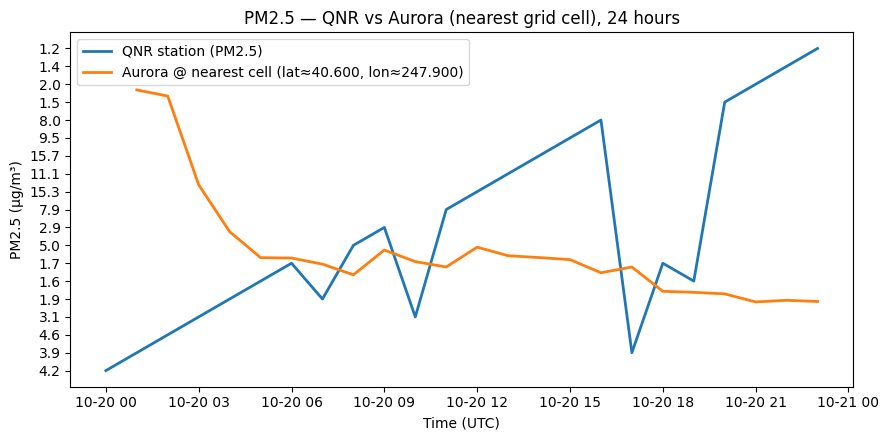

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- file paths (edit if needed) ---
station_csv = "./data/QNR.2025-10-21.csv"                           # your first file
model_csv   = "./predictions/aurora_hourly_utah_2025-10-20.csv"  # your second file

# --- QNR station location ---
site_lat = 40.66284
site_lon = -111.90180
site_lon_0360 = (site_lon + 360.0) if site_lon < 0 else site_lon  # -> 248.09820

# --- load data ---
# --- parse timestamps (UTC) ---
# --- load data ---
df_obs = pd.read_csv(
    station_csv,
    comment="#",            # ignore commented header lines
    skip_blank_lines=True,
    on_bad_lines="skip"     # skip any stray malformed rows
)
df_obs = df_obs[df_obs["Date_Time"].notna()]  # drop the units row

df_mod = pd.read_csv(model_csv)


df_obs["timestamp"] = pd.to_datetime(df_obs["Date_Time"], utc=True)
df_mod["timestamp"] = pd.to_datetime(df_mod["timestamp"], utc=True)

# --- choose the 24h window (from the obs file’s date) ---
day0 = df_obs["timestamp"].dt.floor("D").min()
start = day0
end   = day0 + pd.Timedelta(hours=23)

df_obs_24 = df_obs[(df_obs["timestamp"] >= start) & (df_obs["timestamp"] <= end)].copy()
df_mod_24 = df_mod[(df_mod["timestamp"] >= start) & (df_mod["timestamp"] <= end)].copy()

# --- find nearest model grid point to the site ---
lat_vals = df_mod_24["lat"].unique()
lon_vals = df_mod_24["lon"].unique()

lat_near = lat_vals[np.abs(lat_vals - site_lat).argmin()]
lon_near = lon_vals[np.abs(lon_vals - site_lon_0360).argmin()]

df_mod_pt = df_mod_24[(np.isclose(df_mod_24["lat"], lat_near)) & (np.isclose(df_mod_24["lon"], lon_near))]
# if multiple rows per timestamp slip through, average them
df_mod_ts = df_mod_pt.groupby("timestamp", as_index=False)["pm2p5_ugm3"].mean()

# --- build obs timeseries (column is PM_25_concentration_set_1 in µg/m³) ---
df_obs_ts = df_obs_24[["timestamp", "PM_25_concentration_set_1"]].rename(
    columns={"PM_25_concentration_set_1": "pm2p5_ugm3"}
)

# --- align to hourly index (optional but keeps lines clean) ---
hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")
obs_series = df_obs_ts.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]
mod_series = df_mod_ts.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]

# --- plot ---
plt.figure(figsize=(9, 4.5))
plt.plot(hourly_idx, obs_series, label="QNR station (PM2.5)", linewidth=2)
plt.plot(hourly_idx, mod_series, label=f"Aurora @ nearest cell (lat≈{lat_near:.3f}, lon≈{lon_near:.3f})", linewidth=2)
plt.xlabel("Time (UTC)")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("PM2.5 — QNR vs Aurora (nearest grid cell), 24 hours")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_324688/362168085.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")


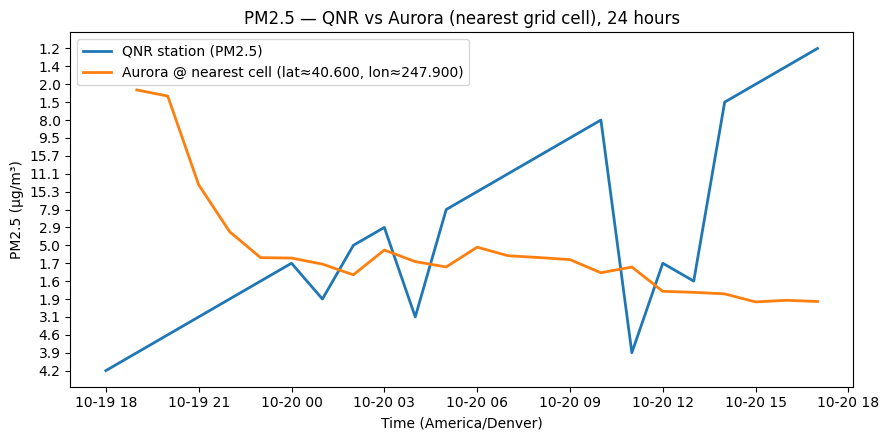

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- file paths (edit if needed) ---
station_csv = "./data/QNR.2025-10-21.csv"                           # your first file
model_csv   = "./predictions/aurora_hourly_utah_2025-10-20.csv"  # your second file

# --- QNR station location ---
site_lat = 40.66284
site_lon = -111.90180
site_lon_0360 = (site_lon + 360.0) if site_lon < 0 else site_lon  # -> 248.09820

# --- load data ---
# --- parse timestamps (UTC) ---
# --- load data ---
df_obs = pd.read_csv(
    station_csv,
    comment="#",            # ignore commented header lines
    skip_blank_lines=True,
    on_bad_lines="skip"     # skip any stray malformed rows
)
df_obs = df_obs[df_obs["Date_Time"].notna()]  # drop the units row

df_mod = pd.read_csv(model_csv)


df_obs["timestamp"] = pd.to_datetime(df_obs["Date_Time"], utc=True)
df_mod["timestamp"] = pd.to_datetime(df_mod["timestamp"], utc=True)

# --- choose the 24h window (from the obs file’s date) ---
day0 = df_obs["timestamp"].dt.floor("D").min()
start = day0
end   = day0 + pd.Timedelta(hours=23)

df_obs_24 = df_obs[(df_obs["timestamp"] >= start) & (df_obs["timestamp"] <= end)].copy()
df_mod_24 = df_mod[(df_mod["timestamp"] >= start) & (df_mod["timestamp"] <= end)].copy()

# --- find nearest model grid point to the site ---
lat_vals = df_mod_24["lat"].unique()
lon_vals = df_mod_24["lon"].unique()

lat_near = lat_vals[np.abs(lat_vals - site_lat).argmin()]
lon_near = lon_vals[np.abs(lon_vals - site_lon_0360).argmin()]

df_mod_pt = df_mod_24[(np.isclose(df_mod_24["lat"], lat_near)) & (np.isclose(df_mod_24["lon"], lon_near))]
# if multiple rows per timestamp slip through, average them
df_mod_ts = df_mod_pt.groupby("timestamp", as_index=False)["pm2p5_ugm3"].mean()

# --- build obs timeseries (column is PM_25_concentration_set_1 in µg/m³) ---
df_obs_ts = df_obs_24[["timestamp", "PM_25_concentration_set_1"]].rename(
    columns={"PM_25_concentration_set_1": "pm2p5_ugm3"}
)

# --- align to hourly index (optional but keeps lines clean) ---
hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")
obs_series = df_obs_ts.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]
mod_series = df_mod_ts.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]

# --- plot ---
tz = "America/Denver"
obs_series_mt = obs_series.tz_convert(tz)
mod_series_mt = mod_series.tz_convert(tz)

# --- plot in Mountain Time ---
plt.figure(figsize=(9, 4.5))
plt.plot(obs_series_mt.index, obs_series_mt, label="QNR station (PM2.5)", linewidth=2)
plt.plot(mod_series_mt.index, mod_series_mt, label=f"Aurora @ nearest cell (lat≈{lat_near:.3f}, lon≈{lon_near:.3f})", linewidth=2)
plt.xlabel("Time (America/Denver)")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("PM2.5 — QNR vs Aurora (nearest grid cell), 24 hours")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
#####################################
# ALL DATA Create UTAH/SLC SLICE csv contains hour timestamp
# PM2.5 from CAMS via Microsoft Aurora — Utah/SLC subset
# Robust single full-window inference with >= 8 * patch_size per dim
# - Ensures sizes are multiples of patch_size and lat↓ / lon↑
# - Returns index slices to cut static grids consistently
# - NO PLOT; CSV includes pm1, pm10, ozone, NO2, NO, CO, SO2 columns
# - CSV now saves a timestamp with hour (YYYY-MM-DD HH:MM:SS)
#####################################

import gc, math, pickle
from pathlib import Path

import numpy as np
import torch
import xarray as xr
from huggingface_hub import hf_hub_download
import pandas as pd

from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ config / paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2025-10-20-cams-surface-level.nc"
atmo_path = download_path / "2025-10-20-cams-atmospheric.nc"
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

out_dir = Path("./predictions")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "pollutant_prediction_utah.csv"

# ------------------ REGION BOUNDS (degrees) ------------------
# Use 0..360 longitudes 
UTAH_BBOX = dict(lat_min=37.0, lat_max=42.1, lon_min=245.9, lon_max=251.0)
SLC_BBOX  = dict(lat_min=40.4, lat_max=41.1, lon_min=247.7, lon_max=248.4)

# Choose region here:
BBOX = SLC_BBOX   # or UTAH_BBOX

# ------------------ helpers ------------------
def detect_lon_domain(ds_lon: np.ndarray) -> str:
    lon_min = float(np.nanmin(ds_lon)); lon_max = float(np.nanmax(ds_lon))
    return "0_360" if lon_min >= 0 and lon_max > 180 else "-180_180"

def to_dataset_lon(lon_vals, target_domain: str):
    """Map longitude(s) into the dataset's domain. Accepts scalar/array."""
    arr = np.asarray(lon_vals, dtype=float)
    if target_domain == "0_360":
        arr = arr % 360.0
        arr = np.where(arr < 0, arr + 360.0, arr)
    else:
        arr = ((arr + 180.0) % 360.0) - 180.0
    return float(arr) if np.ndim(lon_vals) == 0 else arr

def ensure_model_orientation(ds: xr.Dataset) -> xr.Dataset:
    """Ensure lon strictly increasing, lat strictly decreasing (Aurora requirement)."""
    out = ds
    if out.longitude.size >= 2 and not np.all(np.diff(out.longitude.values) > 0):
        out = out.isel(longitude=np.argsort(out.longitude.values))
    if out.latitude.size >= 2 and not np.all(np.diff(out.latitude.values) < 0):
        out = out.isel(latitude=slice(None, None, -1))
    if out.latitude.size >= 2:
        assert np.all(np.diff(out.latitude.values) < 0), "lat must be strictly decreasing"
    if out.longitude.size >= 2:
        assert np.all(np.diff(out.longitude.values) > 0), "lon must be strictly increasing"
    return out

def slice_bbox_value(ds: xr.Dataset, bbox: dict) -> xr.Dataset:
    """Value-based bbox slice (handles lon domain + any lat order)."""
    lat = ds.latitude; lon = ds.longitude
    lon_domain = detect_lon_domain(lon.values)
    lon_min_ds, lon_max_ds = to_dataset_lon([bbox["lon_min"], bbox["lon_max"]], lon_domain)
    lat_min, lat_max = bbox["lat_min"], bbox["lat_max"]

    if lat[0] > lat[-1]:
        lat_slice = slice(lat_max, lat_min)  # descending
    else:
        lat_slice = slice(lat_min, lat_max)  # ascending

    if lon_min_ds <= lon_max_ds:
        lon_slice = slice(lon_min_ds, lon_max_ds)
        out = ds.sel(latitude=lat_slice, longitude=lon_slice)
    else:
        left  = ds.sel(latitude=lat_slice, longitude=slice(lon_min_ds, float(lon.values.max())))
        right = ds.sel(latitude=lat_slice, longitude=slice(float(lon.values.min()), lon_max_ds))
        out = xr.concat([left, right], dim="longitude")

    if out.sizes.get("latitude", 0) == 0 or out.sizes.get("longitude", 0) == 0:
        raise RuntimeError("BBox slice returned empty selection. Check bounds & lon domain.")
    return out

def nearest_index(vec, value):
    return int(np.abs(vec - value).argmin())

def roundup_to_multiple(n, m):
    """Smallest multiple of m that is >= n."""
    return ((int(n) + m - 1) // m) * m

def expand_region_indices(base_lat, base_lon, center_lat_raw, center_lon_raw, target_h, target_w):
    """
    Compute (i_start, i_end, j_start, j_end) on the ORIGINAL grid
    around (center_lat_raw, center_lon_raw) for a target_h x target_w window.
    """
    latv = base_lat; lonv = base_lon
    dom = detect_lon_domain(lonv)
    center_lon = float(to_dataset_lon(center_lon_raw, dom))
    center_lat = float(center_lat_raw)

    i0 = nearest_index(latv, center_lat)
    j0 = nearest_index(lonv, center_lon)

    half_h = target_h // 2
    half_w = target_w // 2

    i_start = max(0, i0 - half_h)
    i_end   = min(latv.size, i0 + half_h + (target_h % 2 != 0))
    if i_end - i_start < target_h:
        deficit = target_h - (i_end - i_start)
        i_start = max(0, i_start - deficit//2)
        i_end   = min(latv.size, i_end + math.ceil(deficit/2))

    j_start = max(0, j0 - half_w)
    j_end   = min(lonv.size, j0 + half_w + (target_w % 2 != 0))
    if j_end - j_start < target_w:
        deficit = target_w - (j_end - j_start)
        j_start = max(0, j_start - deficit//2)
        j_end   = min(lonv.size, j_end + math.ceil(deficit/2))

    # clamp + ensure non-empty
    i_start = max(0, min(i_start, latv.size-1))
    i_end   = max(i_start+1, min(i_end,   latv.size))
    j_start = max(0, min(j_start, lonv.size-1))
    j_end   = max(j_start+1, min(j_end,   lonv.size))
    return i_start, i_end, j_start, j_end

def sizes_multiple_of_ps(ds: xr.Dataset, ps: int) -> bool:
    H = ds.sizes["latitude"]; W = ds.sizes["longitude"]
    return (H % ps == 0) and (W % ps == 0)

def crop_to_multiple_of_ps(ds: xr.Dataset, ps: int) -> xr.Dataset:
    """Crop dataset so H and W are multiples of patch size (keeps top-left corner)."""
    H = ds.sizes["latitude"]; W = ds.sizes["longitude"]
    Hc = (H // ps) * ps
    Wc = (W // ps) * ps
    return ds.isel(latitude=slice(0, Hc), longitude=slice(0, Wc))

def safe_time_tuple(ds):
    if "valid_time" in ds:
        vt = np.asarray(ds.valid_time.values)
        if vt.ndim == 0: vt = vt[None]
        return tuple(pd.to_datetime(vt).to_pydatetime())
    return tuple()

# ------------------ load static vars ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ open datasets ------------------
surf_base = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmo_base = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)
# single analysis time for this demo
if "forecast_period" in surf_base.dims: surf_base = surf_base.isel(forecast_period=0)
if "forecast_period" in atmo_base.dims: atmo_base = atmo_base.isel(forecast_period=0)

# ------------------ model & patch size ------------------
model = AuroraAirPollution()
model.load_checkpoint()
model.eval()
ps = int(model.patch_size)
print("patch_size:", ps)

# Swin3D uses multiple spatial downsamplings; require >= 8 patches per dim
MIN_PATCHES_PER_DIM = 8
min_cells = MIN_PATCHES_PER_DIM * ps

# ------------------ prelim slice (diag) ------------------
surf_reg0 = slice_bbox_value(surf_base, BBOX)
atmo_reg0 = slice_bbox_value(atmo_base, BBOX)
H0, W0 = surf_reg0.sizes["latitude"], surf_reg0.sizes["longitude"]
print(f"Prelim slice size (HxW): {H0} x {W0}")

# ------------------ compute target sizes ------------------
target_H = max(min_cells, roundup_to_multiple(max(H0, min_cells), ps))
target_W = max(min_cells, roundup_to_multiple(max(W0, min_cells), ps))

# ------------------ build single window by indices (and keep slices) ----------
lat_center_raw = 0.5 * (BBOX["lat_min"] + BBOX["lat_max"])
lon_center_raw = 0.5 * (BBOX["lon_min"] + BBOX["lon_max"])

# index expansion on ORIGINAL grids (use surf_base as reference for both)
i_start, i_end, j_start, j_end = expand_region_indices(
    surf_base.latitude.values, surf_base.longitude.values,
    lat_center_raw, lon_center_raw,
    target_H, target_W
)

surf_win = surf_base.isel(latitude=slice(i_start, i_end), longitude=slice(j_start, j_end))
atmo_win = atmo_base.isel(latitude=slice(i_start, i_end), longitude=slice(j_start, j_end))

# enforce orientation
surf_win = ensure_model_orientation(surf_win)
atmo_win = ensure_model_orientation(atmo_win)

# crop to multiples of ps
surf_ds = crop_to_multiple_of_ps(surf_win, ps)
atmo_ds = crop_to_multiple_of_ps(atmo_win, ps)

H, W = surf_ds.sizes["latitude"], surf_ds.sizes["longitude"]
print(f"Window after crop (HxW): {H} x {W}")
assert H >= min_cells and W >= min_cells, f"Need >= {min_cells} cells per dim (got {H}x{W}, ps={ps})"
assert sizes_multiple_of_ps(surf_ds, ps) and sizes_multiple_of_ps(atmo_ds, ps), "Not multiples of patch size."

# ------------------ cut static grids to the same indices ------------------
def slice_static_like(i_start, i_end, j_start, j_end, orient_like: xr.Dataset, ps: int):
    cut = {}
    for k, arr in static_vars_full.items():
        if arr.ndim == 3:  # (C,H,W)
            arr_cut = arr[:, i_start:i_end, j_start:j_end]
        elif arr.ndim == 2:  # (H,W)
            arr_cut = arr[i_start:i_end, j_start:j_end]
        else:
            cut[k] = arr
            continue
        # mirror latitude flip done by ensure_model_orientation (if any)
        flipped_lat = not (np.all(np.diff(surf_win.latitude.values) < 0)) if surf_win.latitude.size >= 2 else False
        if flipped_lat:
            if arr_cut.ndim == 3:
                arr_cut = arr_cut[:, ::-1, :]
            else:
                arr_cut = arr_cut[::-1, :]
        # crop to multiples of ps
        if arr_cut.ndim == 3:
            Hc = (arr_cut.shape[1] // ps) * ps
            Wc = (arr_cut.shape[2] // ps) * ps
            arr_cut = arr_cut[:, :Hc, :Wc]
        elif arr_cut.ndim == 2:
            Hc = (arr_cut.shape[0] // ps) * ps
            Wc = (arr_cut.shape[1] // ps) * ps
            arr_cut = arr_cut[:Hc, :Wc]
        cut[k] = arr_cut
    return cut

static_vars_tile = slice_static_like(i_start, i_end, j_start, j_end, surf_ds, ps)

# ------------------ single full-window inference ------------------
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

surf_vars = {
    "2t":    torch.from_numpy(surf_ds["t2m" ].values[None]),
    "10u":   torch.from_numpy(surf_ds["u10" ].values[None]),
    "10v":   torch.from_numpy(surf_ds["v10" ].values[None]),
    "msl":   torch.from_numpy(surf_ds["msl" ].values[None]),
    "pm1":   torch.from_numpy(surf_ds["pm1" ].values[None]),
    "pm2p5": torch.from_numpy(surf_ds["pm2p5"].values[None]),
    "pm10":  torch.from_numpy(surf_ds["pm10"].values[None]),
    "tcco":  torch.from_numpy(surf_ds["tcco"].values[None]),
    "tc_no": torch.from_numpy(surf_ds["tc_no"].values[None]),
    "tcno2": torch.from_numpy(surf_ds["tcno2"].values[None]),
    "gtco3": torch.from_numpy(surf_ds["gtco3"].values[None]),
    "tcso2": torch.from_numpy(surf_ds["tcso2"].values[None]),
}
atmos_vars = {
    "t":   torch.from_numpy(atmo_ds["t" ].values[None]),
    "u":   torch.from_numpy(atmo_ds["u" ].values[None]),
    "v":   torch.from_numpy(atmo_ds["v" ].values[None]),
    "q":   torch.from_numpy(atmo_ds["q" ].values[None]),
    "z":   torch.from_numpy(atmo_ds["z"].values[None]),
    "co":  torch.from_numpy(atmo_ds["co"].values[None]),
    "no":  torch.from_numpy(atmo_ds["no"].values[None]),
    "no2": torch.from_numpy(atmo_ds["no2"].values[None]),
    "go3": torch.from_numpy(atmo_ds["go3"].values[None]),
    "so2": torch.from_numpy(atmo_ds["so2"].values[None]),
}

batch = Batch(
    surf_vars=surf_vars,
    static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
    atmos_vars=atmos_vars,
    metadata=Metadata(
        lat=torch.from_numpy(atmo_ds.latitude.values),   # strictly decreasing
        lon=torch.from_numpy(atmo_ds.longitude.values),  # strictly increasing
        time=safe_time_tuple(atmo_ds),
        atmos_levels=tuple(int(x) for x in atmo_ds.pressure_level.values),
    ),
)

with torch.inference_mode():
    pred = model(batch)

# PM2.5 prediction (kg/m^3 -> µg/m^3)
pm25_kgm3 = pred.surf_vars["pm2p5"][0, 0].cpu().numpy().astype(np.float32)
pm25_ugm3 = pm25_kgm3 / 1e-9

# ------------------ assemble CSV (no plotting) ------------------
# Consistent orientation for export: lat increasing for human readability
lat_vec = atmo_ds.latitude.values.copy()   # decreasing
lon_vec = atmo_ds.longitude.values.copy()  # increasing
lat_out = lat_vec.copy()
pm25_out = pm25_ugm3.copy()
flip_lat = lat_out[0] > lat_out[-1]
if flip_lat:
    lat_out = lat_out[::-1]
    pm25_out = pm25_out[::-1, :]

# Helper to extract + orient 2D fields like PM1/PM10 (surface) in µg/m^3
def surf_pm_as_ugm3(varname):
    arr = surf_ds[varname].values  # (time?, H, W) or (H,W)
    if arr.ndim == 3: arr = arr[0]
    arr = arr / 1e-9  # kg/m^3 -> µg/m^3
    if flip_lat: arr = arr[::-1, :]
    return arr

pm1_ugm3  = surf_pm_as_ugm3("pm1")
pm10_ugm3 = surf_pm_as_ugm3("pm10")

# Near-surface gases from the atmospheric cube:
# Pick the highest pressure level (closest to the surface)
plevs = atmo_ds.pressure_level.values
k_surface = int(np.argmax(plevs))  # highest pressure

def atmo_surface_field(name):
    v = atmo_ds[name].values  # (plev, H, W) or (time?,plev,H,W)
    if v.ndim == 4: v = v[0, k_surface]
    elif v.ndim == 3: v = v[k_surface]
    else: raise RuntimeError(f"Unexpected dims for {name}: {v.shape}")
    if flip_lat: v = v[::-1, :]
    return v

ozone = atmo_surface_field("go3")
nitrogen_dioxide = atmo_surface_field("no2")
nitrogen_monoxide = atmo_surface_field("no")
carbon_monoxide   = atmo_surface_field("co")
sulfur_dioxide    = atmo_surface_field("so2")

# Build 2D lon/lat grids
LON2D, LAT2D = np.meshgrid(lon_vec, lat_out)

# --- timestamp with hour (ISO-like string) ---
# Use valid_time from the atmo_ds (after isel); if absent, set None
try:
    vt = np.asarray(atmo_ds.valid_time.values)
    if vt.ndim == 0: 
        vt = vt[None]
    # choose the first (only) time
    sel_time_iso = pd.to_datetime(vt[0]).strftime("%Y-%m-%d %H:%M:%S")
except Exception:
    sel_time_iso = None

df = pd.DataFrame({
    "timestamp":          sel_time_iso,  # string column -> always shows hour
    "latitude":           LAT2D.ravel(),
    "longitude":          LON2D.ravel(),
    "pm2p5_ugm3":         pm25_out.ravel(),
    "pm1_ugm3":           pm1_ugm3.ravel(),
    "pm10_ugm3":          pm10_ugm3.ravel(),
    "ozone":              ozone.ravel(),
    "nitrogen_dioxide":   nitrogen_dioxide.ravel(),
    "nitrogen_monoxide":  nitrogen_monoxide.ravel(),
    "carbon_monoxide":    carbon_monoxide.ravel(),
    "sulfur_dioxide":     sulfur_dioxide.ravel(),
})

# Drop NaNs and save
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna().reset_index(drop=True)
df.to_csv(csv_path, index=False)
print(f"Saved CSV: {csv_path}")
print(f"Final working size (HxW): {pm25_kgm3.shape[0]} x {pm25_kgm3.shape[1]}  (ps={ps}, min required: {MIN_PATCHES_PER_DIM*ps})")
print(df.head(10))


patch_size: 3
Prelim slice size (HxW): 1 x 1
Window after crop (HxW): 24 x 24
Saved CSV: predictions/pollutant_prediction_utah.csv
Final working size (HxW): 24 x 24  (ps=3, min required: 24)
             timestamp  latitude  longitude  pm2p5_ugm3  pm1_ugm3  pm10_ugm3  \
0  2025-10-20 00:00:00      36.4      243.2    6.144454  2.515953   4.962630   
1  2025-10-20 00:00:00      36.4      243.6    6.554677  3.670983   7.366880   
2  2025-10-20 00:00:00      36.4      244.0    7.013986  3.739067   7.631770   
3  2025-10-20 00:00:00      36.4      244.4    6.963577  3.815977   7.465333   
4  2025-10-20 00:00:00      36.4      244.8    7.344985  4.195292   7.300032   
5  2025-10-20 00:00:00      36.4      245.2    7.183073  3.435723   5.515376   
6  2025-10-20 00:00:00      36.4      245.6    6.622933  2.241485   3.401483   
7  2025-10-20 00:00:00      36.4      246.0    6.147038  1.801929   2.471069   
8  2025-10-20 00:00:00      36.4      246.4    5.931744  1.503060   2.060887   
9  2025-1

In [10]:
#####################################
# PM2.5 from CAMS via Microsoft Aurora — Utah/SLC subset
# Multi-hour lead-time with real T=2 histories
# FIXED: preserves vertical (L) dimension for atmos vars
# EXTENDED: saves all surface variables (PM1, PM10, gases, met vars)
#####################################

import gc, pickle
from pathlib import Path
import numpy as np
import torch
import xarray as xr
import pandas as pd
from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2025-10-20-lead_time-cams-surface-level.nc"
atmo_path = download_path / "2025-10-20-lead_time-cams-atmospheric.nc"
static_path = download_path / "aurora-0.4-air-pollution-static.pickle"

out_dir = Path("./predictions")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "pollutant_prediction_utah_hourly_full.csv"

UTAH_BBOX = dict(lat_min=37.0, lat_max=42.1, lon_min=245.9, lon_max=251.0)
BBOX = UTAH_BBOX

# ------------------ helpers ------------------
def detect_lon_domain(ds_lon):
    lon_min = float(np.nanmin(ds_lon)); lon_max = float(np.nanmax(ds_lon))
    return "0_360" if lon_min >= 0 and lon_max > 180 else "-180_180"

def to_dataset_lon(lon_vals, domain):
    arr = np.asarray(lon_vals, dtype=float)
    if domain == "0_360":
        arr = arr % 360.0
        arr = np.where(arr < 0, arr + 360.0, arr)
    else:
        arr = ((arr + 180.0) % 360.0) - 180.0
    return float(arr) if np.ndim(lon_vals) == 0 else arr

def ensure_model_orientation(ds):
    if ds.longitude.size >= 2 and not np.all(np.diff(ds.longitude.values) > 0):
        ds = ds.isel(longitude=np.argsort(ds.longitude.values))
    if ds.latitude.size >= 2 and not np.all(np.diff(ds.latitude.values) < 0):
        ds = ds.isel(latitude=slice(None, None, -1))
    return ds

def slice_bbox(ds, bbox):
    lat = ds.latitude; lon = ds.longitude
    domain = detect_lon_domain(lon.values)
    lon_min_ds, lon_max_ds = to_dataset_lon([bbox["lon_min"], bbox["lon_max"]], domain)
    lat_min, lat_max = bbox["lat_min"], bbox["lat_max"]
    if lat[0] > lat[-1]:
        lat_slice = slice(lat_max, lat_min)
    else:
        lat_slice = slice(lat_min, lat_max)
    lon_slice = slice(lon_min_ds, lon_max_ds)
    return ds.sel(latitude=lat_slice, longitude=lon_slice)

def trim_to_patch_multiple(ds, patch_size):
    h, w = ds.sizes["latitude"], ds.sizes["longitude"]
    Hc = (h // patch_size) * patch_size
    Wc = (w // patch_size) * patch_size
    if (Hc, Wc) != (h, w):
        print(f"Trimming from ({h},{w}) → ({Hc},{Wc})")
        ds = ds.isel(latitude=slice(0, Hc), longitude=slice(0, Wc))
    return ds

# ------------------ static + datasets ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)

surf_all = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmo_all = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)

if "forecast_period" in surf_all.dims:
    surf_all = surf_all.rename({"forecast_period": "time"})
if "forecast_period" in atmo_all.dims:
    atmo_all = atmo_all.rename({"forecast_period": "time"})

surf_all = ensure_model_orientation(slice_bbox(surf_all, BBOX))
atmo_all = ensure_model_orientation(slice_bbox(atmo_all, BBOX))

# model
model = AuroraAirPollution()
model.load_checkpoint()
model.eval()
ps = int(model.patch_size)
print("patch_size:", ps)

surf_all = trim_to_patch_multiple(surf_all, ps)
atmo_all = trim_to_patch_multiple(atmo_all, ps)

# time mapping
surf_periods = surf_all["time"].values
atmo_periods = atmo_all["time"].values
atmo_for_surf_idx = np.searchsorted(atmo_periods, surf_periods, side="right") - 1
atmo_for_surf_idx = np.clip(atmo_for_surf_idx, 0, len(atmo_periods) - 1)
print("Surface steps:", len(surf_periods), "Atmos steps:", len(atmo_periods))

# static slice
lat = surf_all.latitude.values
lon = surf_all.longitude.values
static_vars_tile = {
    k: (v[:, :len(lat), :len(lon)] if v.ndim == 3 else v[:len(lat), :len(lon)])
    for k, v in static_vars_full.items() if v.ndim in (2, 3)
}

# ref time
if "forecast_reference_time" in surf_all:
    fc_ref = pd.to_datetime(surf_all["forecast_reference_time"].values[0])
else:
    fc_ref = pd.Timestamp("2025-10-20T00:00Z")

# ------------------ main loop ------------------
frames = []
for surf_idx, atmos_idx in enumerate(atmo_for_surf_idx):
    if surf_idx == 0 or atmos_idx < 0:
        continue

    print(f"Processing hour {surf_idx}/{len(surf_periods)-1} (atm idx={atmos_idx})")

    surf_prev = surf_all.isel(time=surf_idx - 1)
    surf_curr = surf_all.isel(time=surf_idx)
    atmo_prev = atmo_all.isel(time=atmos_idx - 1 if atmos_idx > 0 else 0)
    atmo_curr = atmo_all.isel(time=atmos_idx)

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ---- surface vars (1,2,H,W) ----
    surf_vars = {}
    for k, var in {
        "2t": "t2m", "10u": "u10", "10v": "v10", "msl": "msl",
        "pm1": "pm1", "pm2p5": "pm2p5", "pm10": "pm10",
        "tcco": "tcco", "tc_no": "tc_no", "tcno2": "tcno2",
        "gtco3": "gtco3", "tcso2": "tcso2"
    }.items():
        a = np.asarray(surf_prev[var].values)
        b = np.asarray(surf_curr[var].values)
        if a.ndim == 3: a = a[0]
        if b.ndim == 3: b = b[0]
        surf_vars[k] = torch.from_numpy(np.stack([a, b], axis=0)[None].astype(np.float32))

    # ---- atmospheric vars (1,2,L,H,W) ----
    atmos_vars = {}
    for k, var in {
        "t": "t", "u": "u", "v": "v", "q": "q", "z": "z",
        "co": "co", "no": "no", "no2": "no2", "go3": "go3", "so2": "so2"
    }.items():
        arr_prev = np.asarray(atmo_prev[var].values)
        arr_curr = np.asarray(atmo_curr[var].values)
        if arr_prev.ndim == 4:  # (time,L,H,W)
            arr_prev = arr_prev[0]
            arr_curr = arr_curr[0]
        assert arr_prev.ndim == 3, f"{var} expected 3D (L,H,W)"
        atmos_vars[k] = torch.from_numpy(np.stack([arr_prev, arr_curr], axis=0)[None].astype(np.float32))

    # metadata
    abs_time = fc_ref + pd.to_timedelta(surf_curr.time.values)
    batch = Batch(
        surf_vars=surf_vars,
        static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
        atmos_vars=atmos_vars,
        metadata=Metadata(
            lat=torch.from_numpy(atmo_curr.latitude.values),
            lon=torch.from_numpy(atmo_curr.longitude.values),
            time=(pd.Timestamp(abs_time).to_pydatetime(),),
            atmos_levels=tuple(int(x) for x in atmo_curr.pressure_level.values),
        ),
    )

    with torch.inference_mode():
        pred = model(batch)

    # ---------------- OUTPUT EXTRACTION ----------------
    lat_out = atmo_curr.latitude.values
    lon_out = atmo_curr.longitude.values
    flip_lat = lat_out[0] > lat_out[-1]

    def get_pred(name, scale=1.0):
        arr = pred.surf_vars[name][0, 0].cpu().numpy().astype(np.float32)
        if flip_lat: arr = arr[::-1, :]
        return arr * scale

    def get_curr_surf(name, scale=1.0):
        arr = surf_curr[name].values
        if arr.ndim == 3: arr = arr[0]
        if flip_lat: arr = arr[::-1, :]
        return arr * scale

    pm1  = get_pred("pm1",  1e9)
    pm25 = get_pred("pm2p5",1e9)
    pm10 = get_pred("pm10", 1e9)
    co   = get_pred("tcco")
    no   = get_pred("tc_no")
    no2  = get_pred("tcno2")
    o3   = get_pred("gtco3")
    so2  = get_pred("tcso2")

    LON2D, LAT2D = np.meshgrid(lon_out, lat_out)

    frame = pd.DataFrame({
        "time": pd.Timestamp(abs_time),
        "latitude": LAT2D.ravel(),
        "longitude": LON2D.ravel(),
        "pm1_ugm3": pm1.ravel(),
        "pm2p5_ugm3": pm25.ravel(),
        "pm10_ugm3": pm10.ravel(),
        "co": co.ravel(),
        "no": no.ravel(),
        "no2": no2.ravel(),
        "o3": o3.ravel(),
        "so2": so2.ravel(),
    })

    frames.append(frame)

# ------------------ save ------------------
df = pd.concat(frames, ignore_index=True)
df.to_csv(csv_path, index=False)
print(f"\n✅ Saved hourly predictions with all surface variables to {csv_path}")


/tmp/ipykernel_441692/977498284.py:73: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


patch_size: 3
Trimming from (13,13) → (12,12)
Trimming from (13,13) → (12,12)
Surface steps: 25 Atmos steps: 9
Processing hour 1/24 (atm idx=0)
Processing hour 2/24 (atm idx=0)
Processing hour 3/24 (atm idx=1)
Processing hour 4/24 (atm idx=1)
Processing hour 5/24 (atm idx=1)
Processing hour 6/24 (atm idx=2)
Processing hour 7/24 (atm idx=2)
Processing hour 8/24 (atm idx=2)
Processing hour 9/24 (atm idx=3)
Processing hour 10/24 (atm idx=3)
Processing hour 11/24 (atm idx=3)
Processing hour 12/24 (atm idx=4)
Processing hour 13/24 (atm idx=4)
Processing hour 14/24 (atm idx=4)
Processing hour 15/24 (atm idx=5)
Processing hour 16/24 (atm idx=5)
Processing hour 17/24 (atm idx=5)
Processing hour 18/24 (atm idx=6)
Processing hour 19/24 (atm idx=6)
Processing hour 20/24 (atm idx=6)
Processing hour 21/24 (atm idx=7)
Processing hour 22/24 (atm idx=7)
Processing hour 23/24 (atm idx=7)
Processing hour 24/24 (atm idx=8)

✅ Saved hourly predictions with all surface variables to predictions/pollutant_pr

/tmp/ipykernel_441692/1060973243.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")


AttributeError: module 'matplotlib.pyplot' has no attribute 'le'

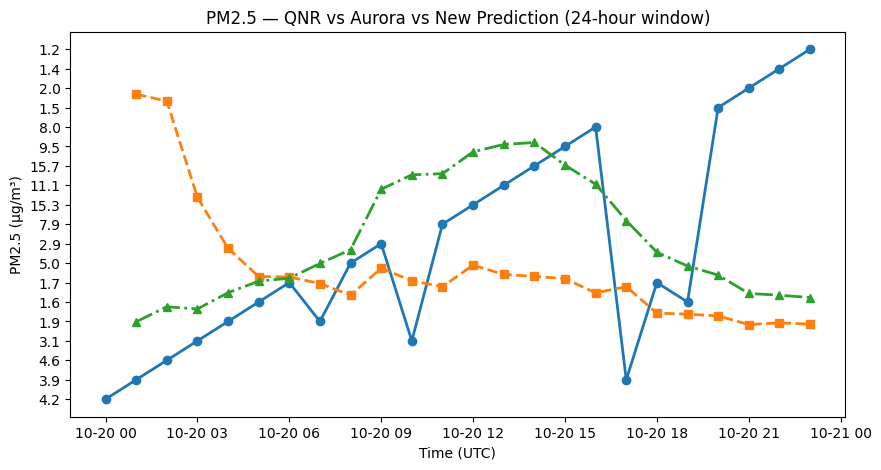

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- file paths (edit if needed) ---
station_csv = "./data/QNR.2025-10-21.csv"
aurora_csv  = "./predictions/aurora_hourly_utah_2025-10-20.csv"
new_csv     = "./predictions/pollutant_prediction_utah_hourly_full.csv"  # new file

# --- QNR station location ---
site_lat = 40.66284
site_lon = -111.90180
site_lon_0360 = (site_lon + 360.0) if site_lon < 0 else site_lon  # 248.09820

# ------------------ LOAD OBS ------------------
df_obs = pd.read_csv(
    station_csv,
    comment="#",
    skip_blank_lines=True,
    on_bad_lines="skip"
)
df_obs = df_obs[df_obs["Date_Time"].notna()]
df_obs["timestamp"] = pd.to_datetime(df_obs["Date_Time"], utc=True)
df_obs_ts = df_obs[["timestamp", "PM_25_concentration_set_1"]].rename(
    columns={"PM_25_concentration_set_1": "pm2p5_ugm3"}
)

# ------------------ LOAD MODEL FILES ------------------
df_aurora = pd.read_csv(aurora_csv)
df_new    = pd.read_csv(new_csv)

# normalize timestamp
df_aurora["timestamp"] = pd.to_datetime(df_aurora["timestamp"], utc=True)
df_new["time"] = pd.to_datetime(df_new["time"], utc=True)

# --- choose the 24h window based on observed file date ---
day0  = df_obs["timestamp"].dt.floor("D").min()
start = day0
end   = day0 + pd.Timedelta(hours=23)

df_obs_24    = df_obs_ts[(df_obs_ts["timestamp"] >= start) & (df_obs_ts["timestamp"] <= end)].copy()
df_aurora_24 = df_aurora[(df_aurora["timestamp"] >= start) & (df_aurora["timestamp"] <= end)].copy()
df_new_24    = df_new[(df_new["time"] >= start) & (df_new["time"] <= end)].copy()

# ------------------ NEAREST GRID POINTS ------------------
def nearest_point(df, lat_col, lon_col, val_col):
    lat_vals = df[lat_col].unique()
    lon_vals = df[lon_col].unique()
    lat_near = lat_vals[np.abs(lat_vals - site_lat).argmin()]
    lon_near = lon_vals[np.abs(lon_vals - site_lon_0360).argmin()]
    df_pt = df[(np.isclose(df[lat_col], lat_near)) & (np.isclose(df[lon_col], lon_near))]
    df_ts = df_pt.groupby("timestamp" if "timestamp" in df_pt else "time", as_index=False)[val_col].mean()
    return df_ts, lat_near, lon_near

df_aurora_ts, lat_a, lon_a = nearest_point(df_aurora_24, "lat", "lon", "pm2p5_ugm3")
df_new_ts, lat_n, lon_n = nearest_point(df_new_24, "latitude", "longitude", "pm2p5_ugm3")

# ------------------ ALIGN ON HOURLY INDEX ------------------
hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")
obs_series = df_obs_24.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]
aurora_series = df_aurora_ts.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]
new_series = df_new_ts.set_index("time").reindex(hourly_idx)["pm2p5_ugm3"]

# ------------------ PLOT ------------------
plt.figure(figsize=(10, 5))
plt.plot(hourly_idx, obs_series, "o-", label="QNR station (PM2.5)", linewidth=2)
plt.plot(hourly_idx, aurora_series, "s--", label=f"Aurora model @ ({lat_a:.3f},{lon_a:.3f})", linewidth=2)
plt.plot(hourly_idx, new_series, "^-.", label=f"New global model @ ({lat_n:.3f},{lon_n:.3f})", linewidth=2)

plt.xlabel("Time (UTC)")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("PM2.5 — QNR vs Aurora vs New Prediction (24-hour window)")
plt.le


/tmp/ipykernel_441692/2496082332.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")


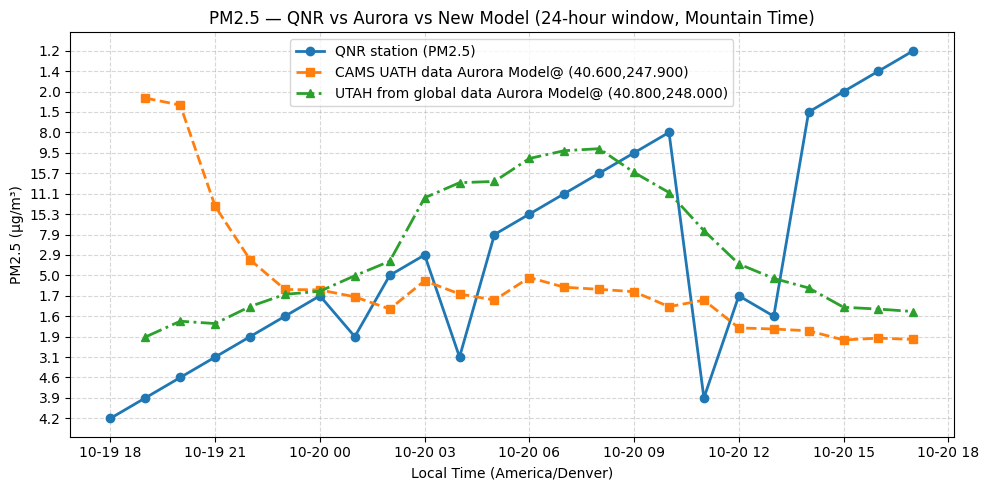

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- file paths (edit if needed) ---
station_csv = "./data/QNR.2025-10-21.csv"
aurora_csv  = "./predictions/aurora_hourly_utah_2025-10-20.csv"
new_csv     = "./predictions/pollutant_prediction_utah_hourly_full.csv"

# --- QNR station location ---
site_lat = 40.66284
site_lon = -111.90180
site_lon_0360 = (site_lon + 360.0) if site_lon < 0 else site_lon  # 248.09820

# ------------------ LOAD OBS ------------------
df_obs = pd.read_csv(
    station_csv,
    comment="#",
    skip_blank_lines=True,
    on_bad_lines="skip"
)
df_obs = df_obs[df_obs["Date_Time"].notna()]
df_obs["timestamp"] = pd.to_datetime(df_obs["Date_Time"], utc=True)
df_obs_ts = df_obs[["timestamp", "PM_25_concentration_set_1"]].rename(
    columns={"PM_25_concentration_set_1": "pm2p5_ugm3"}
)

# ------------------ LOAD MODEL FILES ------------------
df_aurora = pd.read_csv(aurora_csv)
df_new    = pd.read_csv(new_csv)

df_aurora["timestamp"] = pd.to_datetime(df_aurora["timestamp"], utc=True)
df_new["time"] = pd.to_datetime(df_new["time"], utc=True)

# --- choose the 24h window ---
day0  = df_obs["timestamp"].dt.floor("D").min()
start = day0
end   = day0 + pd.Timedelta(hours=23)

df_obs_24    = df_obs_ts[(df_obs_ts["timestamp"] >= start) & (df_obs_ts["timestamp"] <= end)].copy()
df_aurora_24 = df_aurora[(df_aurora["timestamp"] >= start) & (df_aurora["timestamp"] <= end)].copy()
df_new_24    = df_new[(df_new["time"] >= start) & (df_new["time"] <= end)].copy()

# ------------------ NEAREST GRID POINTS ------------------
def nearest_point(df, lat_col, lon_col, val_col):
    lat_vals = df[lat_col].unique()
    lon_vals = df[lon_col].unique()
    lat_near = lat_vals[np.abs(lat_vals - site_lat).argmin()]
    lon_near = lon_vals[np.abs(lon_vals - site_lon_0360).argmin()]
    df_pt = df[(np.isclose(df[lat_col], lat_near)) & (np.isclose(df[lon_col], lon_near))]
    df_ts = df_pt.groupby("timestamp" if "timestamp" in df_pt else "time", as_index=False)[val_col].mean()
    return df_ts, lat_near, lon_near

df_aurora_ts, lat_a, lon_a = nearest_point(df_aurora_24, "lat", "lon", "pm2p5_ugm3")
df_new_ts, lat_n, lon_n = nearest_point(df_new_24, "latitude", "longitude", "pm2p5_ugm3")

# ------------------ ALIGN ON HOURLY INDEX ------------------
hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")
obs_series = df_obs_24.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]
aurora_series = df_aurora_ts.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]
new_series = df_new_ts.set_index("time").reindex(hourly_idx)["pm2p5_ugm3"]

# ------------------ CONVERT TO MOUNTAIN TIME ------------------
mountain_tz = "America/Denver"
hourly_idx_mt = hourly_idx.tz_convert(mountain_tz)
obs_series.index = hourly_idx_mt
aurora_series.index = hourly_idx_mt
new_series.index = hourly_idx_mt

# ------------------ PLOT ------------------
plt.figure(figsize=(10, 5))
plt.plot(hourly_idx_mt, obs_series, "o-", label="QNR station (PM2.5)", linewidth=2)
plt.plot(hourly_idx_mt, aurora_series, "s--", label=f"CAMS UATH data Aurora Model@ ({lat_a:.3f},{lon_a:.3f})", linewidth=2)
plt.plot(hourly_idx_mt, new_series, "^-.", label=f"UTAH from global data Aurora Model@ ({lat_n:.3f},{lon_n:.3f})", linewidth=2)

plt.xlabel("Local Time (America/Denver)")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("PM2.5 — QNR vs Aurora vs New Model (24-hour window, Mountain Time)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
